In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [10]:
release=None

In [15]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-03,2021-02-02,United Kingdom,K02000001,2934,NaN,222.0,606382.0
1,2021-02-03,2021-02-01,United Kingdom,K02000001,17616,NaN,591.0,643204.0
2,2021-02-03,2021-01-31,United Kingdom,K02000001,14880,NaN,660.0,574012.0
3,2021-02-03,2021-01-30,United Kingdom,K02000001,16381,NaN,714.0,439006.0
4,2021-02-03,2021-01-29,United Kingdom,K02000001,21647,2651.0,878.0,662675.0
...,...,...,...,...,...,...,...,...
365,2021-02-03,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
366,2021-02-03,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
367,2021-02-03,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
368,2021-02-03,2020-01-31,United Kingdom,K02000001,2,NaN,NaN,NaN


In [16]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-03.csv')

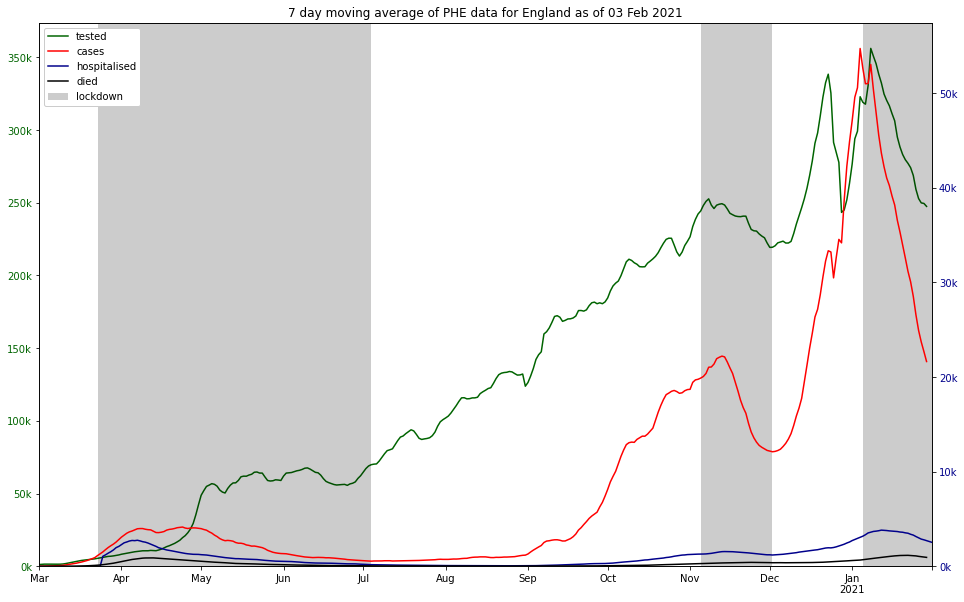

In [17]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [18]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-03.csv')

In [19]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-03.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,25155.0,246671.0,221516.0,1893667,1.328375,11.697727,86.973898
1,Scotland,S92000003,8758.0,649262.0,640504.0,5463300,0.160306,11.723757,88.115937
2,Wales,W92000004,1160.0,462497.0,461337.0,3152879,0.036792,14.632246,85.330963
3,England,E92000001,463889.0,8663041.0,8199152.0,56286961,0.824150,14.566699,84.609151


'partial: 10,021,471'

'full: 498,962'

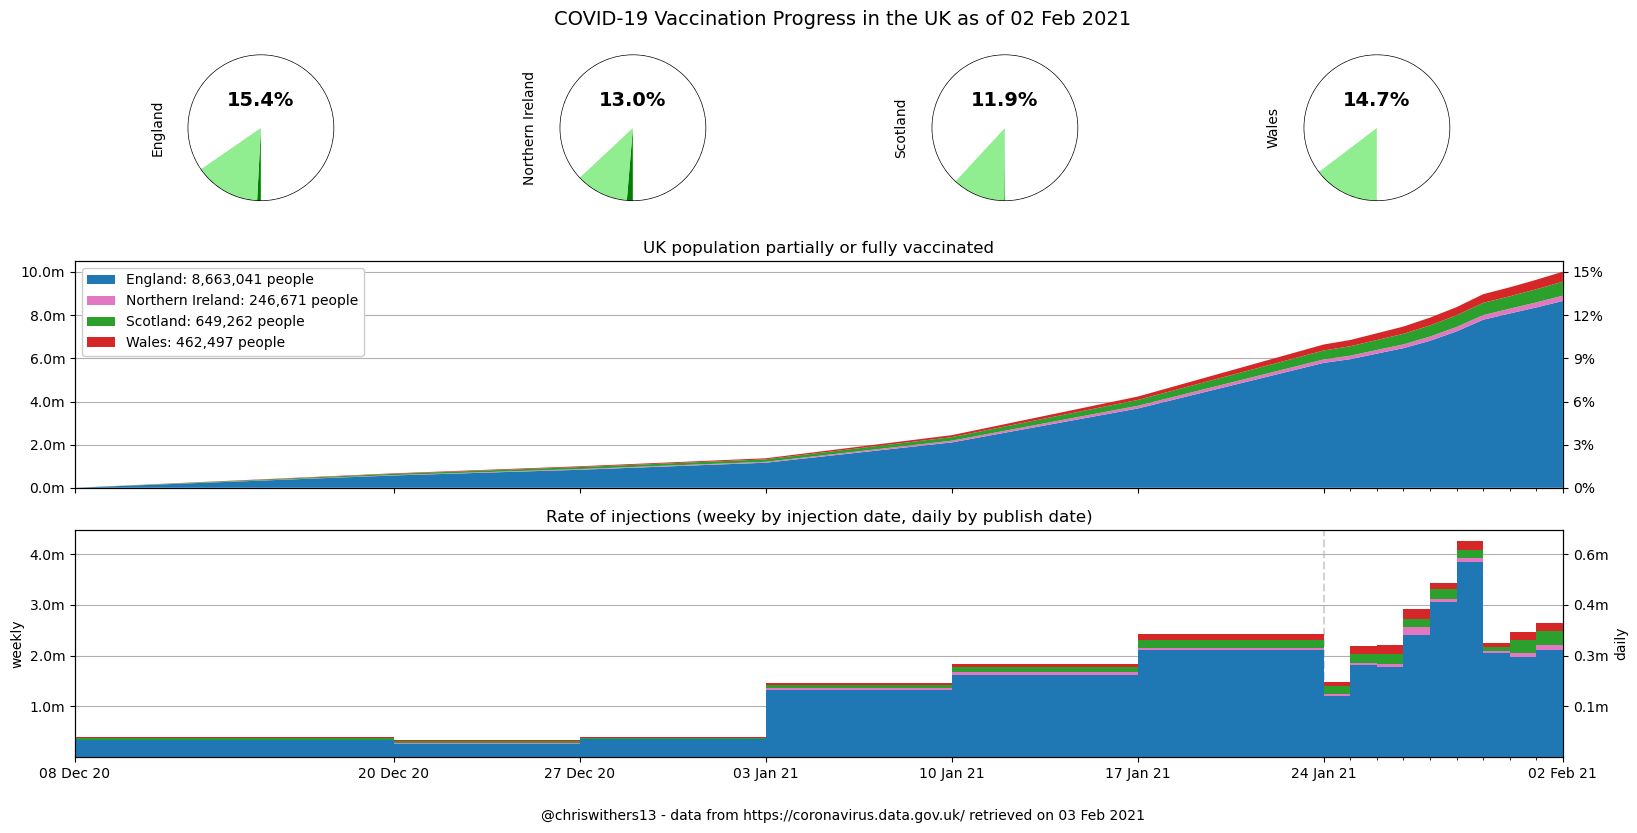

In [2]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [21]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,02 Feb 21,"+300,173","+1,386","+1,386","+8,663,041","+463,889","+463,889"
Northern Ireland,02 Feb 21,"+13,242",+273,+273,"+246,671","+25,155","+25,155"
Scotland,02 Feb 21,"+38,484",+413,+413,"+649,262","+8,758","+8,758"
Wales,02 Feb 21,"+22,857",+94,+94,"+462,497","+1,160","+1,160"


In [22]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-03.csv')

In [23]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-03.csv')

In [24]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-03.csv')

In [26]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-02-03, release: 2021-02-03 16:00:19.745847+00:00, msoa: 2021-02-02 16:21:32+00:00
